Multi-source MTD model geometry
====

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from sbp_modelling.multi_source.model import MultiSourceModel, density_0, density_1
from sbp_modelling.multi_source.forward_model import a_x_s, a_z_s, seeds, temp_x, smoothed_waterbottom, flight_height
from string import ascii_lowercase

plt.style.use('./mpl/manuscript.mplstyle')
cmap = ListedColormap(['#caf0f8'] + ['#ffe8d6'] * 10 + ['#ddbea9'])

In [2]:
model = MultiSourceModel()

params = [(a_x, a_z_s[0], 1001) for a_x in (model.no_aniso, 50.)]

In [3]:
def get_pixel_dimensions(ax):
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    return round(width * fig.dpi) * 4, round(height * fig.dpi) * 4

0.5 0.5
SBP_CACHE_PATH unset
0.5 0.5
SBP_CACHE_PATH unset


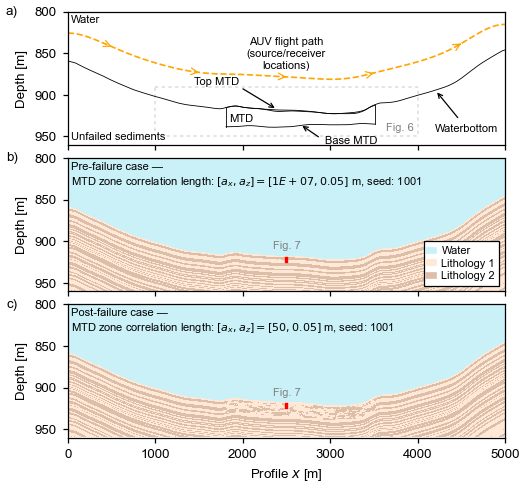

In [4]:
plt.rcParams['figure.figsize'][1] = plt.rcParams['figure.figsize'][0]
fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=False)
fig.subplots_adjust(hspace=0.1)
#cmap = plt.cm.seismic

extent = [model.x.min(), model.x.max(), model.z.max(), model.z.min()]

for i, (a_x, a_z, seed) in enumerate(params):
    width, height = get_pixel_dimensions(ax[i + 1])
    factor = 1
    d_x = 0.5 # (model.x.max() - model.x.min()) / (width * factor)
    d_z = 0.5 # (model.z.max() - model.z.min()) / (height * factor)
    
    print(d_x, d_z)
    
    m = MultiSourceModel(a_x, a_z, seed, subsampling=(d_x, d_z))
    realisation = ax[i + 1].imshow(m.elastic_model(cache=False)[2].T,
        aspect='auto', extent=extent, cmap=cmap, interpolation='gaussian', vmin=1.0, vmax=density_1) # , shading='nearest', rasterized=True)

    if i == 0:
        label = 'Pre-failure case'
    else:
        label = 'Post-failure case'
    ax[i + 1].annotate(f'{label} —\nMTD zone correlation length: $[a_x, a_z]=[{a_x:G}, {a_z}]$ m, seed: {seed}', xy=(model.x.min(), model.z.min()),
               va='top', ha='left', xytext=(2, -2), textcoords='offset points', fontsize='small')

waterbottom, mtd_x, mtd_z, mtd_top, mtd_base = model.horizons()

ax[0].plot(model.x, waterbottom, 'k', linewidth=0.5)
ax[0].plot(model.x[mtd_x], mtd_top[mtd_x], 'k', linewidth=0.5)
ax[0].plot(
    [model.x[mtd_x][-1], model.x[mtd_x][-1]],
    [mtd_top[mtd_x][-1], mtd_base[mtd_x][-1]], 'k', linewidth=0.5)
ax[0].plot(model.x[mtd_x], mtd_base[mtd_x], 'k', linewidth=0.5)
ax[0].plot(
    [model.x[mtd_x][0], model.x[mtd_x][0]],
    [mtd_top[mtd_x][0], mtd_base[mtd_x][0]], 'k', linewidth=0.5)

track = np.vstack((temp_x, smoothed_waterbottom - flight_height)).T
ax[0].plot(*track.T, '--', color='orange', linewidth=1)

n = track.shape[0]
p = 100

for i in 10, 30, 50, 70, 90:
    ax[0].annotate('',
            xy=track[i * n // p],
            xytext=track[i * n // p - n // p],
            arrowprops=dict(arrowstyle="->", ec='orange', fc='none'),
            size=10
        )

ax[0].annotate('Unfailed sediments', xy=(model.x.min(), model.z.max()),
               va='bottom', ha='left', xytext=(2, 2), textcoords='offset points', fontsize='small')
ax[0].annotate('MTD', xy=(model.x[mtd_x].min(), model.z[mtd_z].max()),
               va='bottom', ha='left', xytext=(2, 2), textcoords='offset points', fontsize='small')
ax[0].annotate('Water', xy=(model.x.min(), model.z.min()),
               va='top', ha='left', xytext=(2, -2), textcoords='offset points', fontsize='small')
ax[0].annotate('AUV flight path\n(source/receiver\nlocations)', xy=track[n // 2],
               va='bottom', ha='center', xytext=(0, 4), textcoords='offset points', fontsize='small')

lithologies = {
    'Water': Line2D([0], [0], color=cmap(0.), lw=4),
    'Lithology 1': Line2D([0], [0], color=cmap(0.5), lw=4),
    'Lithology 2': Line2D([0], [0], color=cmap(1.), lw=4)
}
ax[-2].legend(lithologies.values(), lithologies.keys(), handlelength=0.4,
             loc='lower right', fontsize='small')

for i in 0, 1, 2:
    ax[i].set_xlim(model.x.min(), model.x.max())
    ax[i].set_xticks(np.linspace(0, 5000, 6))
    ax[i].set_ylim(model.z.min(), 960)
    ax[i].set(ylabel='Depth [m]')
    ax[i].annotate(f'{ascii_lowercase[i]})', xy=(0, 1), xytext=(-30, 0),
                   textcoords='offset points', xycoords='axes fraction', va='center', ha='right')
    ax[i].invert_yaxis()

ax[-1].set(xlabel='Profile $x$ [m]')

x_0, x_1 = 1000, 4000
z_0, z_1 = 890, 950

ax[0].add_patch(Rectangle((x_0, z_0), x_1 - x_0, z_1 - z_0, facecolor='none',
                          edgecolor='gray', linewidth=0.25, linestyle=(0, (8, 8))))
ax[0].annotate('Fig. 6', xy=(x_1, z_1), xytext=(-2, 2), textcoords='offset points',
               color='gray', va='bottom', ha='right', fontsize='small')

ax[0].annotate('Waterbottom', xy=(4200, 894), xytext=(0, -25), textcoords='offset points',
               arrowprops=dict(arrowstyle='->'), fontsize='small')
ax[0].annotate('Top MTD', xy=(2400, 918), xytext=(-50, 15), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', relpos=(1, 0), shrinkA=0), fontsize='small')
ax[0].annotate('Base MTD', xy=(2650, 935), xytext=(15, -12), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', relpos=(0, 0.5)), fontsize='small')

for a in ax[1], ax[2]:
    x_core = 2500
    core_length = 4
    zz = waterbottom[np.argmin(np.abs(model.x - 2500))] + 1.5
    a.plot([x_core, x_core], [zz, zz + core_length], linewidth=2, color='red')
    a.annotate('Fig. 7', xy=(x_core, zz), xytext=(0, 4), textcoords='offset points', color='gray',
               va='bottom', ha='center', fontsize='small')

In [5]:
fig.savefig('../../manuscript/figures/fig05.pdf')